In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retinal-oct-c8/README.md
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1127.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1076.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1059.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1084.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1193.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1261.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1132.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1060.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1080.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1281.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Da

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Paths (update if needed, but usually it's like this in Kaggle)
data_dir = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"

train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "val")
test_dir  = os.path.join(data_dir, "test")

print("Train classes:", os.listdir(train_dir))
print("Val classes:", os.listdir(val_dir))
print("Test classes:", os.listdir(test_dir))


Train classes: ['DR', 'AMD', 'CSR', 'DRUSEN', 'CNV', 'NORMAL', 'MH', 'DME']
Val classes: ['DR', 'AMD', 'CSR', 'DRUSEN', 'CNV', 'NORMAL', 'MH', 'DME']
Test classes: ['DR', 'AMD', 'CSR', 'DRUSEN', 'CNV', 'NORMAL', 'MH', 'DME']


In [3]:
# Transforms (augment for train, only resize+normalize for val/test)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir,  transform=val_test_transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print("Classes:", class_names)
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(val_dataset))
print("Number of test images:", len(test_dataset))


Classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']
Number of training images: 18400
Number of validation images: 2800
Number of test images: 2800


In [4]:
# Load pretrained DenseNet121
model = models.densenet121(pretrained=True)

# Freeze feature extractor (optional: speeds up training, but less flexible)
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier (final fully connected layer)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, len(class_names))

print(model)  # just to check


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 138MB/s] 

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [5]:
# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


Using device: cuda


In [6]:
import copy
import time

def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, save_path="best_densenet121.pth"):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        start = time.time()
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save checkpoint (every epoch)
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

        # Save best model (highest val accuracy)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"✅ Best model updated at epoch {epoch+1}")

        print(f"Epoch time: {(time.time()-start):.1f} sec")

    print("\nTraining complete. Best val acc: {:.4f}".format(best_acc))

    # Load best weights before returning
    model.load_state_dict(best_model_wts)
    return model, history


In [7]:
model, history = train_model(
    model, criterion, optimizer,
    train_loader, val_loader,
    device, num_epochs=10,
    save_path="best_densenet121.pth"
)



Epoch 1/10
--------------------
Train Loss: 0.8683 Acc: 0.7054
Val   Loss: 0.5718 Acc: 0.7868
✅ Best model updated at epoch 1
Epoch time: 167.4 sec

Epoch 2/10
--------------------
Train Loss: 0.5775 Acc: 0.7907
Val   Loss: 0.5461 Acc: 0.7957
✅ Best model updated at epoch 2
Epoch time: 92.2 sec

Epoch 3/10
--------------------
Train Loss: 0.5254 Acc: 0.8067
Val   Loss: 0.4241 Acc: 0.8475
✅ Best model updated at epoch 3
Epoch time: 92.8 sec

Epoch 4/10
--------------------
Train Loss: 0.4967 Acc: 0.8140
Val   Loss: 0.4461 Acc: 0.8329
Epoch time: 92.8 sec

Epoch 5/10
--------------------
Train Loss: 0.4789 Acc: 0.8187
Val   Loss: 0.4211 Acc: 0.8439
Epoch time: 91.5 sec

Epoch 6/10
--------------------
Train Loss: 0.4710 Acc: 0.8216
Val   Loss: 0.3847 Acc: 0.8600
✅ Best model updated at epoch 6
Epoch time: 92.0 sec

Epoch 7/10
--------------------
Train Loss: 0.4592 Acc: 0.8247
Val   Loss: 0.3980 Acc: 0.8479
Epoch time: 93.2 sec

Epoch 8/10
--------------------
Train Loss: 0.4490 Acc: 0.

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load best model weights
model.load_state_dict(torch.load("best_densenet121.pth"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.80      0.77      0.79       350
         CSR       0.92      0.97      0.95       350
         DME       0.78      0.77      0.77       350
          DR       0.94      0.89      0.91       350
      DRUSEN       0.71      0.65      0.68       350
          MH       0.94      0.93      0.94       350
      NORMAL       0.73      0.83      0.78       350

    accuracy                           0.85      2800
   macro avg       0.85      0.85      0.85      2800
weighted avg       0.85      0.85      0.85      2800

Confusion Matrix:
 [[350   0   0   0   0   0   0   0]
 [  0 271   0  29   0  40   0  10]
 [  0   0 341   0   6   0   3   0]
 [  0  24   0 268   0  22   0  36]
 [  0   0  20   1 310   0  18   1]
 [  0  41   0  20   0 229   0  60]
 [  0   0   8   0  15   0 327   0]
 [  0   4   0  24   0  32   0 290]]


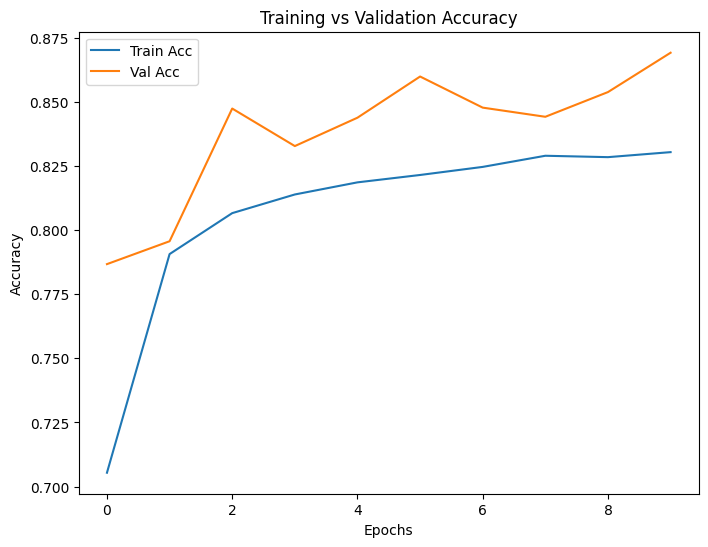

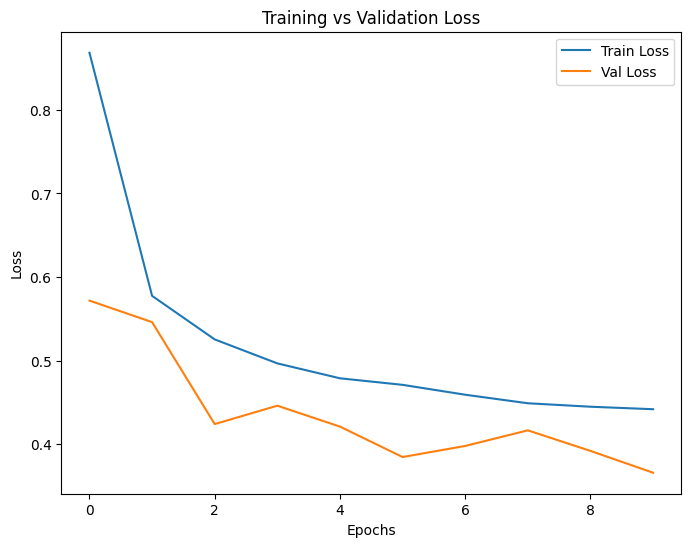

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8,6))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


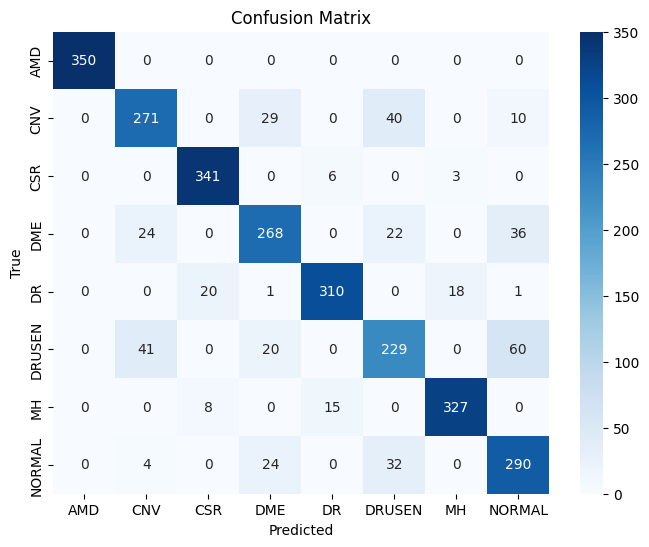

In [10]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


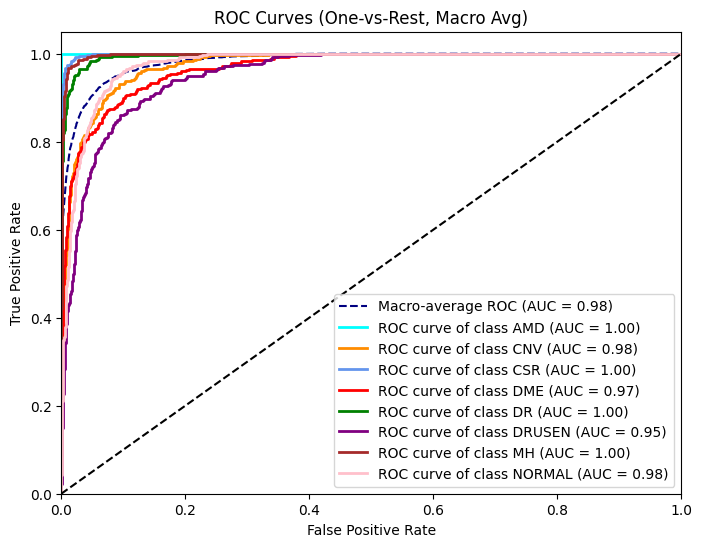

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Get probabilities for ROC
y_true = []
y_prob = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Binarize labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
fpr["macro"], tpr["macro"], roc_auc["macro"] = all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr["macro"], tpr["macro"], color="navy", linestyle="--",
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "purple", "brown", "pink"])
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest, Macro Avg)")
plt.legend(loc="lower right")
plt.show()


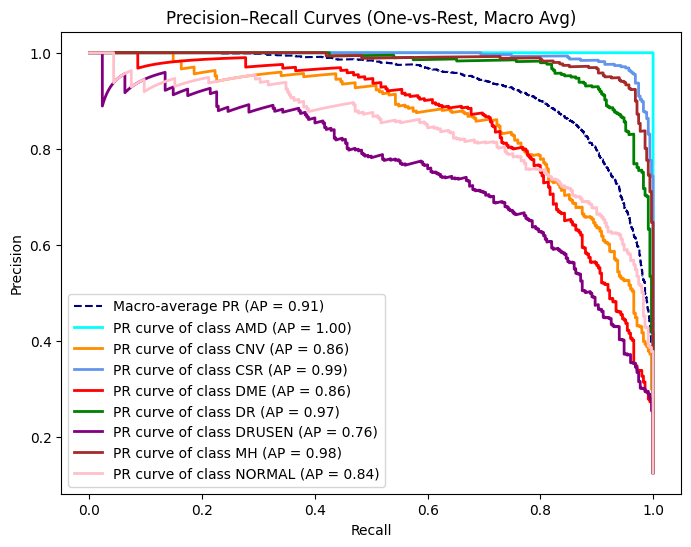

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute PR curve and Average Precision (AP) for each class
precision, recall, avg_precision = dict(), dict(), dict()
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Compute macro-average Precision-Recall
precision["macro"], recall["macro"], _ = precision_recall_curve(
    y_true_bin.ravel(), y_prob.ravel()
)
avg_precision["macro"] = average_precision_score(y_true_bin, y_prob, average="macro")

# Plot PR curves
plt.figure(figsize=(8,6))
plt.plot(recall["macro"], precision["macro"], color="navy", linestyle="--",
         label=f"Macro-average PR (AP = {avg_precision['macro']:.2f})")

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "purple", "brown", "pink"])
for i, color in zip(range(len(class_names)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f"PR curve of class {class_names[i]} (AP = {avg_precision[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (One-vs-Rest, Macro Avg)")
plt.legend(loc="lower left")
plt.show()
